# NLP BBC News Classification based LSTM Algorithm

Predict emotion from textual data : Multi-class text classification

---

**Training Accuracy**
- loss: 0.41
- acc: 100.00

**Validation Accuracy**
- loss: 44.98
- acc: 91.01

In [20]:
# install library needed
!pip install -q kaggle
!pip install unidecode
!pip install chart_studio

     |████████████████████████████████| 71kB 4.7MB/s 


In [186]:
# import library needed
import nltk
import spacy
import string
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer

from tensorflow import keras
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, GlobalMaxPooling1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import sequence, pad_sequences
from keras.utils.vis_utils import plot_model

from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn
import numpy as np
import pandas as pd

import os
import re
import time
import uuid
import warnings
from IPython.display import Markdown
from IPython.display import display
from slugify import slugify
import cufflinks as cf
import plotly.io as pio

In [68]:
# ignore the unwanted warning messages
warnings.filterwarnings('ignore')
# enambling iplot
cf.go_offline()
pio.renderers.default = 'colab'

In [69]:
# downloading nltk resource
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [71]:
# Define base path for worksheet
BASE_PATH = '/content/drive/MyDrive/Playground/BBCNews'
# No. of class
NUM_CLASS=5
# No. of number of samples that will be propagated through the network
BATCH_SIZE=128
# Learning rate
LEARNING_RATE=0.001
# Number of iterations
EPOCH=50

In [6]:
# mount our google drive
drive.mount('/content/drive')

Mounted at /content/drive


## Helper

In [166]:
# Print in markdown format
def printmd(string):
    display(Markdown(string))

# Plot training loss and accuracy
def plot_training(history, title, save=True, save_path=os.path.join(BASE_PATH, 'visualization')):
    printmd("### Training Loss and Accuracy")
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch_list = range(1, len(acc) + 1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc=0, fontsize='large')
    plt.xlabel("Epoch #", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.show()
    
    if save is True:
        filename = slugify(title) + '_loss_model.png'
        plt.savefig(save_path + '/' + filename)

    plt.figure(figsize=(8, 6))
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc=4, fontsize='large')
    plt.xlabel("Epoch #", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()
    
    if save is True:
        filename = slugify(title) + '_acc_model.png'
        plt.savefig(save_path + '/' + filename)

# Table classification report
def table_classification_report(classes, preds):
    printmd('#### Classification Report')
    target_names = ['business', 'entertainment', 'politics', 'sport', 'tech']
    print(classification_report(classes, preds, target_names=target_names))

    print('Accuracy: {:.2f}\n'.format(accuracy_score(classes, preds)))

    print('Macro Precision: {:.2f}'.format(precision_score(classes, preds, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(classes, preds, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(classes, preds, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(classes, preds, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(classes, preds, average='weighted')))
    print('Weighted F1-score: {:.2f}\n'.format(f1_score(classes, preds, average='weighted')))

# Evaluate model, confusion matrix and classification report
def model_evaluation(title, model, x_train, x_test, y_train, y_test, save=True, save_path=os.path.join(BASE_PATH, 'visualization')):
    printmd('### Training Accuracy')
    loss, val_acc = model.evaluate(x_train, y_train, verbose=1)

    print("loss: %.2f" % (loss*100))
    print("acc: %.2f" % (val_acc*100))
    
    printmd('### Validation Accuracy')
    loss, val_acc = model.evaluate(x_test, y_test, verbose=1)

    print("loss: %.2f" % (loss*100))
    print("acc: %.2f" % (val_acc*100))
    
    printmd('### Evaluation of Model Performance')
    y_pred = model.predict(x_test, verbose=1)
    
    # Table classification report
    table_classification_report(y_test, y_pred.round())

## Preprocessing

### Data Gatering

In [7]:
# upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imamkusniadi","key":"30fa97395ea7d3c066e0aff94a241f54"}'}

In [8]:
# make directory and change permission
!mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json && ls ~/.kaggle

kaggle.json


In [9]:
# download the dataset
!kaggle datasets download -d yufengdev/bbc-fulltext-and-category

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 61.9MB/s]


In [11]:
# unziping dataset and move to playground
!unzip bbc-fulltext-and-category.zip -d /content/drive/MyDrive/Playground/BBCNews/

Archive:  bbc-fulltext-and-category.zip
  inflating: /content/drive/MyDrive/Playground/BBCNews/bbc-text.csv  


In [12]:
# remove downloaded dataset
!rm -rf bbc-fulltext-and-category.zip

### Load Dataset

In [14]:
# load dataset
dataset = os.path.join(BASE_PATH, 'bbc-text.csv')
df = pd.read_csv(dataset, sep=',')
print('Dataset loaded ...')

Dataset loaded ...


### Data Exploration

In [15]:
# get the first rows on dataset
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [16]:
# total data
df.count()

category    2225
text        2225
dtype: int64

In [17]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [18]:
# simple metric study
df['category'].describe()

count      2225
unique        5
top       sport
freq        511
Name: category, dtype: object

In [30]:
# print distribution of category/class
df.groupby('category').count()['text'].iplot(
    kind='bar',
    xTitle='category',
    linecolor='black',
    yTitle='count',
    title='Category/Class Distribution')

### Data Cleaning & Normalization

In [53]:
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = stopwords.words("english")

def preprocess(text):
  # convert text to lower
  text = text.lower()
  # remove username (using @), URLs and hastag
  text = re.sub("@\S+|http\S+|#\S+", "", text)
  # get rid of non words and extra spaces
  text = re.sub('\\W', ' ', text)
  text = re.sub('(?<=[a-z])\'(?=[a-z])', '', text)
  text = re.sub("(?<=[a-z])'(?=[a-z])", "", text)
  text = re.sub('\n', '', text)
  text = re.sub(' +', ' ', text)
  text = re.sub('^ ', '', text)
  text = re.sub(' $', '', text)
  # remove punctuactions
  text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
  # convert into ascii
  text = unidecode(text)
  # tokenized
  tokenized = word_tokenize(text)
  # remove stopwords
  remove_stopwords = [token for token in tokenized if token.isalnum() and token not in STOPWORDS]
  # clean_token = [token for token in tokenized if token.isalnum()]
  clean_string = " ".join(remove_stopwords)
  return clean_string

In [54]:
df["text_preprocessed"] = df["text"].apply(lambda text: preprocess(text))
df.head()

,category,text,text_preprocessed
0,tech,tv future in the hands of viewers with home th...,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raids box office ocean twelve cri...


In [55]:
# data category one-hot-encoding
category = pd.get_dummies(df.category)
df_category = pd.concat([df, category], axis=1)
df_category = df_category.drop(columns='category')
df_category.head()

,text,text_preprocessed,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,tv future hands viewers home theatre systems p...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,tigers wary farrell gamble leicester say rushe...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,ocean twelve raids box office ocean twelve cri...,0,1,0,0,0


In [56]:
# change dataframe value to numpy array
text_preprocessed = df_category['text_preprocessed'].values
label = df_category[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [57]:
# view text preprocessed array
text_preprocessed

array(['tv future hands viewers home theatre systems plasma high definition tvs digital video recorders moving living room way people watch tv radically different five years time according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes us leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices one talked technologies ces digital personal video recorders dvr pvr set top boxes like us tivo uk sky system allow people record store play pause forward wind tv programmes want essentially technology allows much personalised tv also built high definition tv sets big business japan us slower take europe lack high definition programming people forward wind adverts also forget abiding network channel schedules putting together la carte entertainment us networks cable satellite companies worried means terms advertising reve

In [58]:
# view label array
label

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

### Data Spliting

In [59]:
# split data into training and validation
x_train, x_test, y_train, y_test = train_test_split(text_preprocessed, label, test_size=0.2, shuffle=True)

### Tokenizing and Pad Sequence

In [60]:
# tokinizer
tokenizer = Tokenizer()
# preparing vocubulary
tokenizer.fit_on_texts(list(x_train))

# converting text into integer sequences
sekuens_train = tokenizer.texts_to_sequences(x_train)
sekuens_test = tokenizer.texts_to_sequences(x_test)

# padding to prepare sequences of same length
padded_train = pad_sequences(sekuens_train, maxlen=100)
padded_test = pad_sequences(sekuens_test, maxlen=100)

In [61]:
# get size of vocabulary for embedding input dimension
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print('Size of vocabulary:', size_of_vocabulary)

Size of vocabulary: 26856


## Modeling

In [182]:
def ModelLSTM():
  model = Sequential()

  model.add(Embedding(input_dim=size_of_vocabulary, output_dim=100, input_length=100))
  model.add(SpatialDropout1D(0.2))
  model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences = True)))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dense(64, activation = "relu"))
  model.add(Dense(NUM_CLASS, activation = "softmax"))

  optimizer = Adam()
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

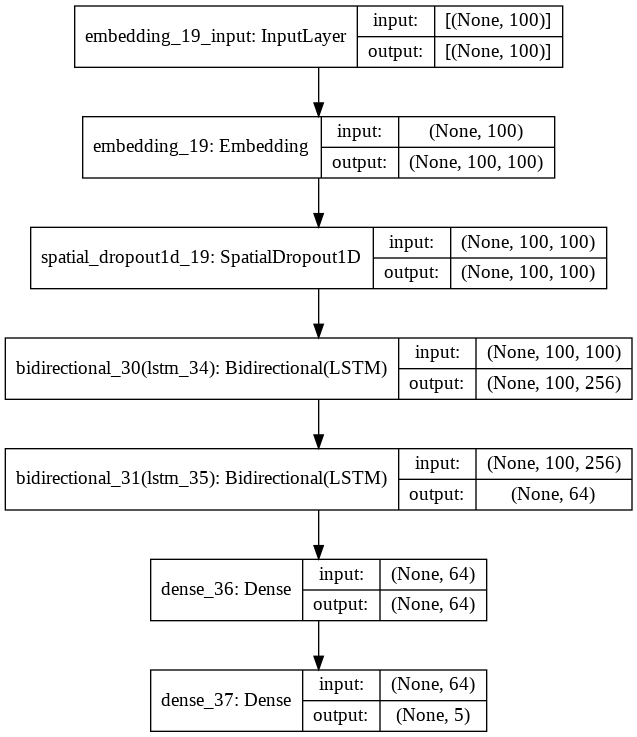

In [183]:
# Visualize LSTM model
plot_model(ModelLSTM(), to_file=os.path.join(BASE_PATH, 'visualization/LSTM.png'), show_shapes=True)

## Training

In [184]:
# Adding callbacks
train_id = 'LSTM-' + str(uuid.uuid1())
best_model = os.path.join(BASE_PATH, 'model/best_model-' + train_id + '.h5')
last_model = os.path.join(BASE_PATH, 'model/last_model-' + train_id + '.h5')
csv_log = os.path.join(BASE_PATH, 'monitor/logs-' + train_id + '.h5')

ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
MC = ModelCheckpoint(best_model, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
CSVL = CSVLogger(csv_log, separator=",", append=True)

callbacks = [MC, ES, CSVL]

Training strated with Train ID: LSTM-25aad1d0-e18c-11eb-a6e4-0242ac1c0002
Epoch 1/50
14/14 [==============================] - 24s 1s/step - loss: 1.6032 - accuracy: 0.2337 - val_loss: 1.5534 - val_accuracy: 0.4247

Epoch 00001: val_accuracy improved from -inf to 0.42472, saving model to /content/drive/MyDrive/Playground/BBCNews/model/best_model-LSTM-25aad1d0-e18c-11eb-a6e4-0242ac1c0002.h5
Epoch 2/50
14/14 [==============================] - 12s 850ms/step - loss: 1.4064 - accuracy: 0.4113 - val_loss: 0.8975 - val_accuracy: 0.6584

Epoch 00002: val_accuracy improved from 0.42472 to 0.65843, saving model to /content/drive/MyDrive/Playground/BBCNews/model/best_model-LSTM-25aad1d0-e18c-11eb-a6e4-0242ac1c0002.h5
Epoch 3/50
14/14 [==============================] - 11s 815ms/step - loss: 0.7660 - accuracy: 0.7224 - val_loss: 0.6554 - val_accuracy: 0.8067

Epoch 00003: val_accuracy improved from 0.65843 to 0.80674, saving model to /content/drive/MyDrive/Playground/BBCNews/model/best_model-LSTM-

### Training Loss and Accuracy

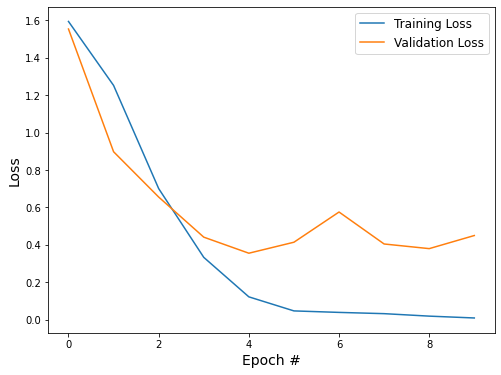

<Figure size 432x288 with 0 Axes>

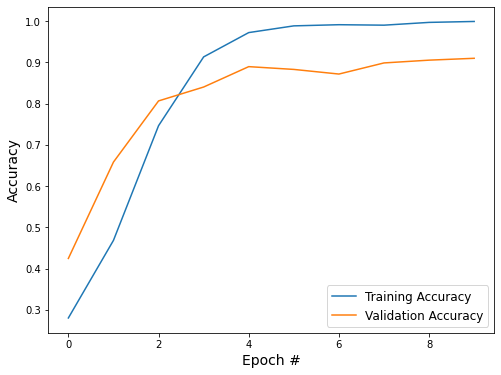

Load best model to evaluate ...


### Training Accuracy

56/56 [==============================] - 6s 57ms/step - loss: 0.0041 - accuracy: 1.0000
loss: 0.41
acc: 100.00


### Validation Accuracy

14/14 [==============================] - 1s 58ms/step - loss: 0.4498 - accuracy: 0.9101
loss: 44.98
acc: 91.01


### Evaluation of Model Performance

14/14 [==============================] - 3s 57ms/step


#### Classification Report

               precision    recall  f1-score   support

     business       0.98      0.86      0.92       101
entertainment       0.95      0.87      0.91        69
     politics       0.79      0.93      0.85        85
        sport       0.95      1.00      0.98        99
         tech       0.91      0.87      0.89        91

    micro avg       0.91      0.91      0.91       445
    macro avg       0.92      0.91      0.91       445
 weighted avg       0.92      0.91      0.91       445
  samples avg       0.91      0.91      0.91       445

Accuracy: 0.91

Macro Precision: 0.92
Macro Recall: 0.91
Macro F1-score: 0.91

Weighted Precision: 0.92
Weighted Recall: 0.91
Weighted F1-score: 0.91



<Figure size 432x288 with 0 Axes>

In [185]:
# Training start time
start_time = time.time()

print("Training strated with Train ID: {}".format(train_id))

model = LSTMv1()
history = model.fit(np.array(padded_train), np.array(y_train),
                  validation_data=(np.array(padded_test),np.array(y_test)),
                  batch_size=BATCH_SIZE,
                  epochs=EPOCH,
                  verbose=1,
                  callbacks=callbacks)

# Training complete
time_elapsed = time.time() - start_time
# Save last model
model.save(last_model)

print("=" * 30)
print("Training Finished, took {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
print("Best model:", best_model)
print("Last model:", last_model)

# Plot training and loss accuracy
plot_training(history, train_id)

# Load best model
print("Load best model to evaluate ...")
model = load_model(best_model)
model_evaluation(train_id, model, padded_train, padded_test, y_train, y_test)

## Prediction

In [192]:
def prediction(model, string):
  seq_str = tokenizer.texts_to_sequences(string)
  enc_str = sequence.pad_sequences(seq_str, maxlen=100)
  pred = model.predict_classes(enc_str)

  news_class = ['business', 'entertainment', 'politics', 'sport', 'tech']
  label = news_class[pred[0]]

  print('String:', string)
  print('Prediction:', label)

In [195]:
# try prediction from https://www.bbc.com/sport/rugby-union/57771397 (Published date: 10 Jul 2021)
string = ["Pumas full-back Juan Cruz Mallia was shown a red card after 29 minutes for a reckless tackle on Kieran Hardy. The Pumas were trailing 6-3 at the time, but rallied through tries from Pablo Matera and Jeronimo De La Fuente and the boot of Nicolas Sanchez. Tries from Will Rowlands and Tomos Williams helped Wales level the scores. Evans lined up the long-range effort in the final minute, but it went wide after Argentina had also missed three penalty attempts. The two sides will meet in the second Test in Cardiff next Saturday (15:00 BST). Wales were indebted to the 47th-minute introduction of replacement half-backs Tomos Williams and Evans, who helped change the game's complexion after Argentina had dominated the contact area."]

prediction(model=model, string=string)

String: ["Pumas full-back Juan Cruz Mallia was shown a red card after 29 minutes for a reckless tackle on Kieran Hardy. The Pumas were trailing 6-3 at the time, but rallied through tries from Pablo Matera and Jeronimo De La Fuente and the boot of Nicolas Sanchez. Tries from Will Rowlands and Tomos Williams helped Wales level the scores. Evans lined up the long-range effort in the final minute, but it went wide after Argentina had also missed three penalty attempts. The two sides will meet in the second Test in Cardiff next Saturday (15:00 BST). Wales were indebted to the 47th-minute introduction of replacement half-backs Tomos Williams and Evans, who helped change the game's complexion after Argentina had dominated the contact area."]
Prediction: sport
